In [0]:
#IMPORTING THE REQUIRED LIBRARIES
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Embedding, RepeatVector, TimeDistributed, Attention
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
from sklearn.model_selection import train_test_split

In [34]:
file = files.upload()

Saving Eng2Mar.txt to Eng2Mar.txt


In [0]:
#FUNCTION TO READ THE FILE 
def read_text(filename):
        file = open(filename, mode='rt', encoding='utf-8')
        text = file.read()
        file.close()
        return text

In [0]:
#SPLITTING THE SENTENCES ON THE BASIS OF ROWS
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [0]:
#READING THE SENTENCES AND CONVERTING THEM INTO ARRAY
data = read_text("Eng2Mar.txt")
eng_mar = to_lines(data)
eng_mar = array(eng_mar)

In [38]:
eng_mar

array([['Go.', 'जा.'],
       ['Run!', 'पळ!'],
       ['Run!', 'धाव!'],
       ...,
       ['Tom tried to sell his old VCR instead of throwing it away, but no one would buy it, so he ended up throwing it away.',
        'टॉमने त्याचा जुना व्ही.सी.आर फेकून टाकण्याऐवजी विकून टाकण्याचा प्रयत्न केला, पण विकत घ्यायला कोणीच तयार नव्हतं, म्हणून त्याला तो शेवटी फेकूनच टाकायला लागला.'],
       ["You can't view Flash content on an iPad. However, you can easily email yourself the URLs of these web pages and view that content on your regular computer when you get home.",
        'आयपॅडवर फ्लॅश आशय बघता येत नाही. पण तुम्ही त्या वेब पानांचे यूआरएल स्वतःला ईमेल करून तोच आशय घरी पोहोचल्यावर आपल्या रोजच्या संगणकावर पाहू शकता.'],
       ['In 1969, Roger Miller recorded a song called "You Don\'t Want My Love." Today, this song is better known as "In the Summer Time." It\'s the first song he wrote and sang that became popular.',
        '१९६९मध्ये रॉजर मिलरने "यू डोन्ट वॉन्ट माय लव्ह" नावाचं गाणं रेकॉर्ड 

In [0]:
eng_mar = eng_mar[:25000,:]   #taking first 25000 sentences

In [40]:
eng_mar.shape

(25000, 2)

In [41]:
# Remove punctuation
eng_mar[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_mar[:,0]]
eng_mar[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in eng_mar[:,1]]

eng_mar

array([['Go', 'जा'],
       ['Run', 'पळ'],
       ['Run', 'धाव'],
       ...,
       ['I forgot to send the letter', 'मी पत्र पाठवायला विसरले'],
       ['I gave it to the little boy', 'मी ते त्या लहान मुलाला दिलं'],
       ['I gave it to the little boy', 'मी ते लहान मुलाला सोपवलं']],
      dtype='<U194')

In [42]:
# convert text to lowercase
for i in range(len(eng_mar)):
    eng_mar[i,0] = eng_mar[i,0].lower()
    eng_mar[i,1] = eng_mar[i,1].lower()

eng_mar

array([['go', 'जा'],
       ['run', 'पळ'],
       ['run', 'धाव'],
       ...,
       ['i forgot to send the letter', 'मी पत्र पाठवायला विसरले'],
       ['i gave it to the little boy', 'मी ते त्या लहान मुलाला दिलं'],
       ['i gave it to the little boy', 'मी ते लहान मुलाला सोपवलं']],
      dtype='<U194')

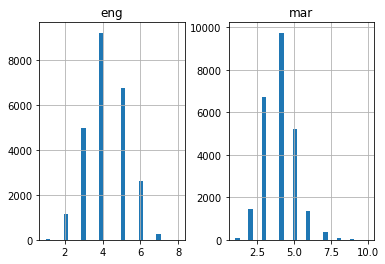

<Figure size 864x720 with 0 Axes>

In [43]:
eng_l = []
mar_l = []

# populate the lists with sentence lengths
for i in eng_mar[:,0]:
      eng_l.append(len(i.split()))

for i in eng_mar[:,1]:
      mar_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'mar':mar_l})

length_df.hist(bins = 30)
plt.figure(figsize=(12,10))
plt.show()

In [0]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [45]:
# prepare English tokenizer
eng_tokenizer = tokenization(eng_mar[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 3581


In [46]:
# prepare Marathi tokenizer
mar_tokenizer = tokenization(eng_mar[:, 1])
mar_vocab_size = len(mar_tokenizer.word_index) + 1

mar_length = 10
print('Marathi Vocabulary Size: %d' % mar_vocab_size)

Marathi Vocabulary Size: 7764


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         seq = tokenizer.texts_to_sequences(lines)
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [0]:
# split data into train and test set
train1, test1 = train_test_split(eng_mar, test_size=0.1, random_state = 1)

**English to Marathi Machine Translation Model**

In [0]:
# prepare training data with English sentences as input and Marathi sentences as output
trainX1 = encode_sequences(eng_tokenizer, eng_length, train1[:, 0])
trainY1 = encode_sequences(mar_tokenizer, mar_length, train1[:, 1])

# prepare validation data
testX1 = encode_sequences(eng_tokenizer, eng_length, test1[:, 0])
testY1 = encode_sequences(mar_tokenizer, mar_length, test1[:, 1])

In [0]:
# building encoder decoder model
# in_timesteps = length of english words
# out_timesteps = length of marathi words
# mask_zero = True as we have used post seq padding which is to be ignored.
# Repeat vector will repeat the input n no of times
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
      return model

In [0]:
model1 = define_model(eng_vocab_size, mar_vocab_size, eng_length, mar_length, 512)

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model1.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [53]:
filename = 'model1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model1.fit(trainX1, trainY1.reshape(trainY1.shape[0], trainY1.shape[1], 1),
                    epochs=50, batch_size=512, validation_split = 0.1,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/50
39/40 [============================>.] - ETA: 0s - loss: 3.5621
Epoch 00001: val_loss improved from inf to 2.75591, saving model to model1.h5
40/40 [==============================] - 5s 121ms/step - loss: 3.5411 - val_loss: 2.7559
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 2.7076
Epoch 00002: val_loss improved from 2.75591 to 2.70034, saving model to model1.h5
40/40 [==============================] - 3s 82ms/step - loss: 2.7076 - val_loss: 2.7003
Epoch 3/50
39/40 [============================>.] - ETA: 0s - loss: 2.6056
Epoch 00003: val_loss improved from 2.70034 to 2.62974, saving model to model1.h5
40/40 [==============================] - 3s 83ms/step - loss: 2.6042 - val_loss: 2.6297
Epoch 4/50
39/40 [============================>.] - ETA: 0s - loss: 2.5313
Epoch 00004: val_loss improved from 2.62974 to 2.57114, saving model to model1.h5
40/40 [==============================] - 3s 85ms/step - loss: 2.5298 - val_loss: 2.5711
Epoch 5/50
39/40 [=====

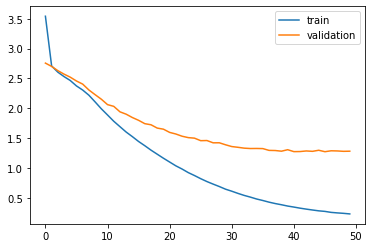

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model1 = load_model('/content/model1.h5')

In [0]:
preds = model1.predict_classes(testX1.reshape((testX1.shape[0],testX1.shape[1])))

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text1 = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], mar_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], mar_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text1.append(' '.join(temp))

In [0]:
pred_df1 = pd.DataFrame({'English': test1[:,0], 'Actual' : test1[:,1], 'Predicted' : preds_text1})

In [61]:
pred_df1.sample(10)

,English,Actual,Predicted
685,its not anybodys fault,कोणाचीच चूक नाहीये,कोणाचीही चूक नाहीये
1338,its me,मी आहे,मी आहे
818,we still need your help,आम्हाला अजूनही तुझ्या मदतीची गरज आहे,आम्हाला अजूनही मदतीची गरज आहे
103,take my handkerchief,माझा रुमाल घ्या,माझा रुमाल घे
1070,did anyone say anything,अजून कोणी काही म्हटलं का,कोणी बघितलं का
887,we have one more year,आपल्याकडे अजून एक वर्ष आहे,आपल्याला अजून एक वर्ष आहे
1391,tom talked,टॉम बोलला,टॉम रडला
2176,do you hear me,तुम्हाला मी ऐकू येतोय का,तुम्हाला मी ऐकू येतेय का
1996,its not tom,टॉम नाहीये,टॉम नाहीये
1907,try again,पुन्हा प्रयत्न करा,पुन्हा प्रयत्न कर


**Marathi to English Machine Translation Model**

In [0]:
# prepare training data for Marathi sentences as input and English sentences as output
trainX2 = encode_sequences(mar_tokenizer, mar_length, train1[:, 1])
trainY2 = encode_sequences(eng_tokenizer, eng_length, train1[:, 0])

# prepare validation data
testX2 = encode_sequences(mar_tokenizer, mar_length, test1[:, 1])
testY2 = encode_sequences(eng_tokenizer, eng_length, test1[:, 0])

In [0]:
# def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
#       model = Sequential()
#       model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
#       model.add(LSTM(units))
#       model.add(RepeatVector(out_timesteps))
#       model.add(LSTM(units, return_sequences=True))
#       model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
#       return model

#The code has been commented as the architecture of the model is the same

In [0]:
# model compilation
model2 = define_model(mar_vocab_size, eng_vocab_size, mar_length, eng_length, 512)

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model2.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [66]:
filename = 'model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history1 = model2.fit(trainX2, trainY2.reshape(trainY2.shape[0], trainY2.shape[1], 1),
                    epochs=50, batch_size=512, validation_split = 0.1,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 4.0199
Epoch 00001: val_loss improved from inf to 3.26471, saving model to model2.h5
40/40 [==============================] - 5s 118ms/step - loss: 4.0199 - val_loss: 3.2647
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 3.2213
Epoch 00002: val_loss improved from 3.26471 to 3.13420, saving model to model2.h5
40/40 [==============================] - 3s 76ms/step - loss: 3.2213 - val_loss: 3.1342
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 3.0909
Epoch 00003: val_loss improved from 3.13420 to 3.07388, saving model to model2.h5
40/40 [==============================] - 3s 78ms/step - loss: 3.0909 - val_loss: 3.0739
Epoch 4/50
39/40 [============================>.] - ETA: 0s - loss: 2.9803
Epoch 00004: val_loss improved from 3.07388 to 2.94440, saving model to model2.h5
40/40 [==============================] - 3s 79ms/step - loss: 2.9754 - val_loss: 2.9444
Epoch 5/50
40/40 [=====

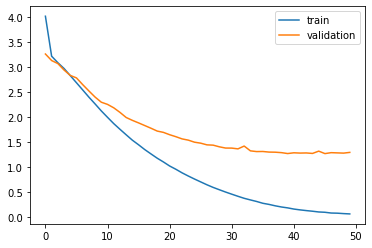

In [67]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model2 = load_model('model2.h5')
preds1 = model2.predict_classes(testX2.reshape((testX2.shape[0],testX2.shape[1])))

In [0]:
preds_text2 = []
for i in preds1:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text2.append(' '.join(temp))

In [0]:
pred_df2 = pd.DataFrame({'Marathi': test1[:,1], 'Actual' : test1[:,0], 'Predicted' : preds_text2})

In [71]:
pred_df2.sample(10)

,Marathi,Actual,Predicted
1043,मी टॉमला दररोज बघतो,i see tom every day,i see tom every day
198,त्या खरेदी करायला गेल्या,she went shopping,she went shopping
1419,त्याला मला फोन करायला सांग,tell him to call me,tell him to call me
1922,स्वतः करून पाहा,try it out yourself,that happened chess
1960,त्याला टेनिस खेळायला आवडतो,he likes to play tennis,he likes to play tennis
2019,आता सर्वांनाच माहीत आहे,everyone knows it now,everyone knows it
1018,मी दररोज शाळेत जाते,i go to school every day,i go to school every day
1919,तू इथे एकटा होतास का,were you here alone,were you here alone
334,तो पिआनो महागडा आहे,the piano is expensive,he is by the him
1266,मरशील,you will die,they will die
